In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi
import magnetic_boundaries as mb

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [57]:
parameters = {
    'width' : 50, # This is in units of 3a
    'length' : 25,
    'bottom_bearded' : True,
    'top_bearded' : False,
    'mag_field' : 0.1,
    'noise' : 0.5,
    'seed' : 0
             }
#Calculate spectrum
#spectrum = mb.graphene_spectrum(parameters)
spectrum = graphene_spectrum(parameters)

(0.0, 100.0)

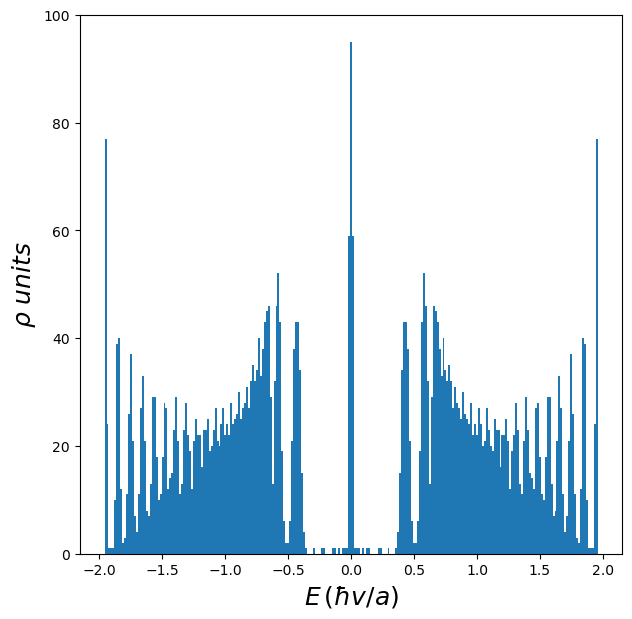

In [58]:
nbins = parameters['width']*parameters['length']//5+1-(parameters['width']*parameters['length']//5)%2
#nbins = 201
density_of_states, bin_edges = np.histogram(spectrum, bins = nbins, density = False)

x = (bin_edges[1:]+bin_edges[:-1])/2
dx = (bin_edges[1]-bin_edges[0])/2

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.bar(x,density_of_states,width = 2*dx)
ax.set_ylabel(r"$\rho$ $units$",fontsize = 18)
ax.set_xlabel(r"$E\,(\hbar v/a)$",fontsize = 18)
#ax.axvline(np.sqrt(2*parameters['mag_field']), c = 'C3')######################## Skipping orbits centered the edge of the ribbon
ax.set_ylim(0,100)

In [ ]:
#What I want to see is the LL structure smeared by disorder. There is a problem with the units of noise, Apparently they are samller than I thought/indend(how can such big disorder do so little?)

In [27]:
def graphene_spectrum(parameters):
    '''
    Finds the spectrum of a graphene square
    with zigzag boundary conditions in x direction
    and open in y direction
    in a uniform magnetic field.
    The units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    Returns
    -spectrum: numpy matrix of size (4*width-2+bottom_bearded+top_bearded)*length
    '''
    parameters['kx'] = 0
    hamiltonian = graphene_square(parameters)
    spectrum = np.linalg.eigvalsh(hamiltonian)

    return spectrum

def graphene_square(parameters):
    '''
    Returns the Hamiltonian for a square
    geometry in a magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    Returns
    -H: numpy matrix of size 4*width-2+bottom_bearded+top_bearded
    '''
    #The parameters dictionary must have the following key,value pairs
    length = parameters['length']     #int Number of lattice unit cells in x direction. Each cell contains 4 sites and it is sqrt(3)a long in x
    width = parameters['width']       #int Number of lattice unit cells in y direction. Each cell contains 4 sites and it is 3a long in y
    kx = parameters['kx']*np.sqrt(3)             # float in (-pi/pi] wavenumber in x direction. The sqrt(3) is because the x-direction lattice site is sqrt(3)a long.
                                                 # This war parameters['k_x'] has units of 1/a
    bottom_bearded = parameters['bottom_bearded'] #bool type of zigzag bc at the bottom
    top_bearded = parameters['top_bearded']       #bool type of zigzag bc at the top
    mag_field = parameters['mag_field']           #float magnetic field
    noise = parameters['noise']       #int disorder strength

    #Let us build the noise array
    fluxes = noise*(np.random.rand(2*width-2,length)-0.5)*3*np.sqrt(3)/2 #Factor to make flux from magnetic field
    random_contribution = np.cumsum(fluxes, axis=0) * ((-1) ** np.arange(fluxes.shape[0]))[:, None]
    random_contribution = np.vstack([np.zeros((1, random_contribution.shape[1])), random_contribution])
    
    np.random.seed(parameters['seed']) #Set the seed before building the matrix
    peierls_factor = np.sqrt(3)/2*mag_field*3 #The 3 is because the y-direction lattice site is 3a long

    hamiltonian = np.zeros(((4*width-2+bottom_bearded+top_bearded)*length,(4*width-2+bottom_bearded+top_bearded)*length),dtype = complex)
    

    def index(orbital,y,x):
        return orbital + 4*y-1+bottom_bearded + (width*4-2+bottom_bearded+top_bearded)*x
        
    ### We have 4 orbitals
    for x in range(length):
        for y in range(width):
            if y!=0 or bottom_bearded:
                hamiltonian[index(0,y,x),index(1,y,x)] += -1
                hamiltonian[index(1,y,x),index(0,y,x)] += -1
            
            hamiltonian[index(1,y,x),index(2,y,x)] += -np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*random_contribution[2*y,x])
            hamiltonian[index(2,y,x),index(1,y,x)] += -np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*random_contribution[2*y,x])
            hamiltonian[index(1,y,x),index(2,y,(x-1)%length)] += -np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*kx*length*(1 if x==0 else 0))
            hamiltonian[index(2,y,(x-1)%length),index(1,y,x)] += -np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*kx*length*(1 if x==0 else 0))
            
    
            if y!=width-1 or top_bearded:
                hamiltonian[index(2,y,x),index(3,y,x)] += -1
                hamiltonian[index(3,y,x),index(2,y,x)] += -1
    
            if y!=width-1:
                hamiltonian[index(3,y,x),index(0,y+1,x)] += -np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*random_contribution[2*y+1,x])
                hamiltonian[index(0,y+1,x),index(3,y,x)] += -np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*random_contribution[2*y+1,x])
                hamiltonian[index(3,y,x),index(0,y+1,(x+1)%length)] += -np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*kx*length*(1 if x==length-1 else 0))
                hamiltonian[index(0,y+1,(x+1)%length),index(3,y,x)] += -np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*kx*length*(1 if x==length-1 else 0))

    return hamiltonian*2/3 #Adjusting units so that the fermi velocity is equal to 1

In [32]:
parameters = {
    'width' : 50, # This is in units of 3a
    'length' : 5,
    'bottom_bearded' : True,
    'top_bearded' : False,
    'mag_field' : 0.1,
    'noise' : 2,
    'seed' : 0
             }
#Calculate spectrum
spectrum = graphene_spectrum(parameters)

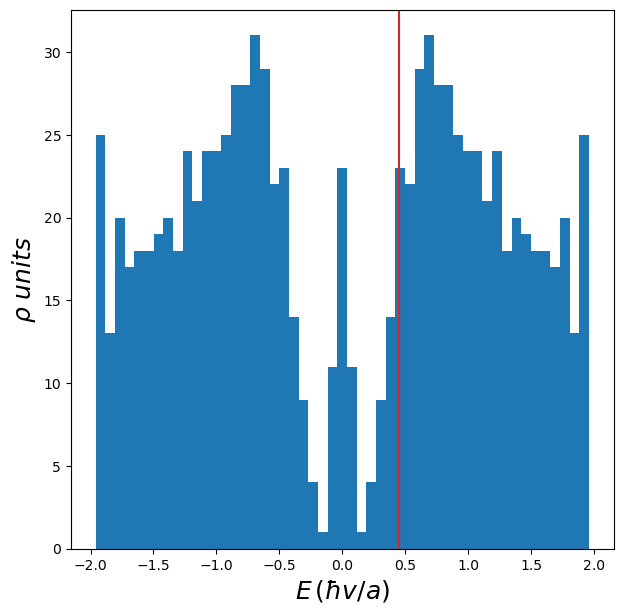

In [33]:
nbins = parameters['width']*parameters['length']//5+1-(parameters['width']*parameters['length']//5)%2
#nbins = 201
density_of_states, bin_edges = np.histogram(spectrum, bins = nbins, density = False)

x = (bin_edges[1:]+bin_edges[:-1])/2
dx = (bin_edges[1]-bin_edges[0])/2

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.bar(x,density_of_states,width = 2*dx)
ax.set_ylabel(r"$\rho$ $units$",fontsize = 18)
ax.set_xlabel(r"$E\,(\hbar v/a)$",fontsize = 18)
ax.axvline(np.sqrt(2*parameters['mag_field']), c = 'C3')######################## Skipping orbits centered the edge of the ribbon
#ax.set_xlim(-0.2,0.2)